In [1]:
# !pip install pytrends
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from pytrends.request import TrendReq
import time
import pandas as pd
import matplotlib
import gtrend

plt.style.use('seaborn-darkgrid')
matplotlib.rcParams['font.family'] = ['Heiti TC']
def rmax(maxrow: int=50):
    pd.set_option('display.max_rows', maxrow)

def cmax(maxcol: int=50):
    pd.set_option('display.max_columns', maxcol)

Setup the query terms and conditions

In [2]:
pytrend = TrendReq(hl='en-US')
keyword = 'brexit'
start = '2016-01-01'
end = '2019-11-23'
geo=''
cat=0
gprop=''

Acquire daily google trend data for over 9 month by concatenating multiple queries, and normalize(scaling) by the overlapping period (overlapping method)

In [3]:
overlapping = gtrend.get_daily_trend(pytrend, keyword, start, end, geo=geo, cat=cat, gprop=gprop, verbose=False)

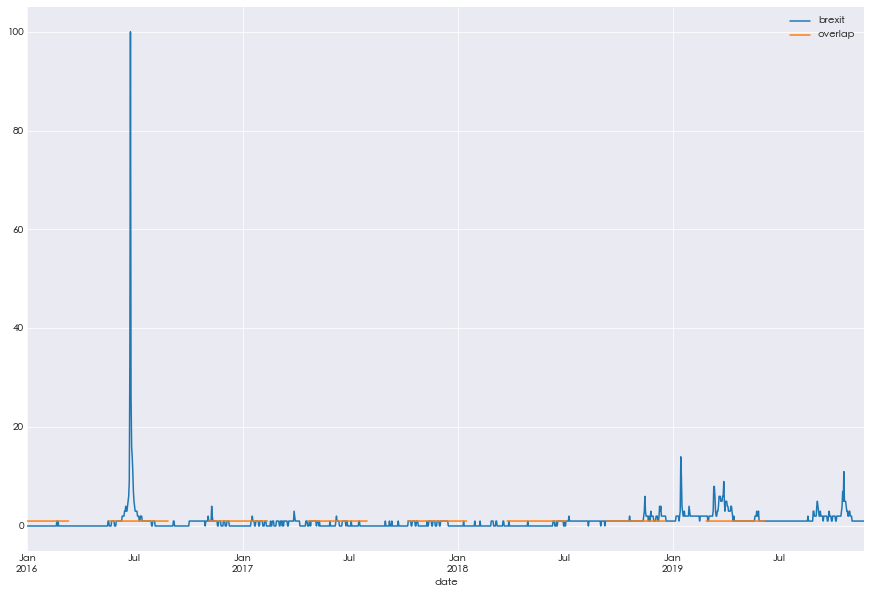

In [4]:
overlapping.plot(figsize=(15,10))

Acquire daily google trend data for over 9 month by concatenating multiple non-overlapping queries of 1-month, and normalize(scaling) by weekly trend value of the same period. (pytrends dailydata.py method)

In [5]:
from pytrends import dailydata

start_d = datetime.strptime(start, '%Y-%m-%d')
end_d = datetime.strptime(end, '%Y-%m-%d')
s_year = start_d.year
s_mon = start_d.month
e_year = end_d.year
e_mon = end_d.month

dailydata = dailydata.get_daily_data(word= keyword,
                 start_year= s_year,
                 start_mon= s_mon,
                 stop_year= e_year,
                 stop_mon= e_mon,
                 geo= geo,
                 verbose= False,
                 wait_time = 1.0)

Index(['brexit_unscaled', 'brexit_monthly', 'isPartial', 'scale', 'brexit'], dtype='object')


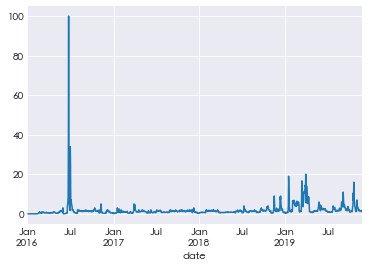

In [6]:
print(dailydata.columns)
dailydata[f'{keyword}'].plot()

The weekly trend data might be a reference for comparing above normalization methods. For query period between 269 days (~9months) and 5 years, google trend will return weely data. 
To have comparable axis scale, the weekly data is interpolated to obtain daily data. 

In [16]:
tf = start_d.strftime('%Y-%m-%d')+' '+end_d.strftime('%Y-%m-%d')
pytrend.build_payload(kw_list=[keyword], cat=cat, geo=geo, gprop=gprop, timeframe=tf)
week = pytrend.interest_over_time()
week_interp = week.resample('D').mean()
week_interp[f'{keyword}'] = week_interp[f'{keyword}'].interpolate()

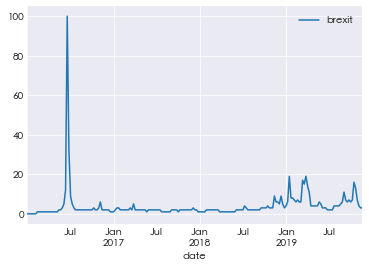

In [19]:
week_interp.drop(columns='isPartial', inplace=True)
week_interp.plot()

For better visual comparison, let's put all 3 dataset together.

In [20]:
overlapping.loc[:,keyword]

date
2016-01-01    0.0
2016-01-02    0.0
2016-01-03    0.0
2016-01-04    0.0
2016-01-05    0.0
             ... 
2019-11-19    1.0
2019-11-20    1.0
2019-11-21    1.0
2019-11-22    1.0
2019-11-23    1.0
Freq: D, Name: brexit, Length: 1423, dtype: float64

In [22]:
combined = pd.concat([overlapping, dailydata.loc[:,keyword], week_interp], axis=1)
combined.columns = ['overlapping method', 'overlap period', 'dailydata method', 'weekly data']

In [24]:
import matplotlib.dates as mdates

combined2 = combined.iloc[:, [0,2,3,1]]
combined2.index = [pd.to_datetime(date, format='%Y-%m-%d').date() for date in combined2.index]

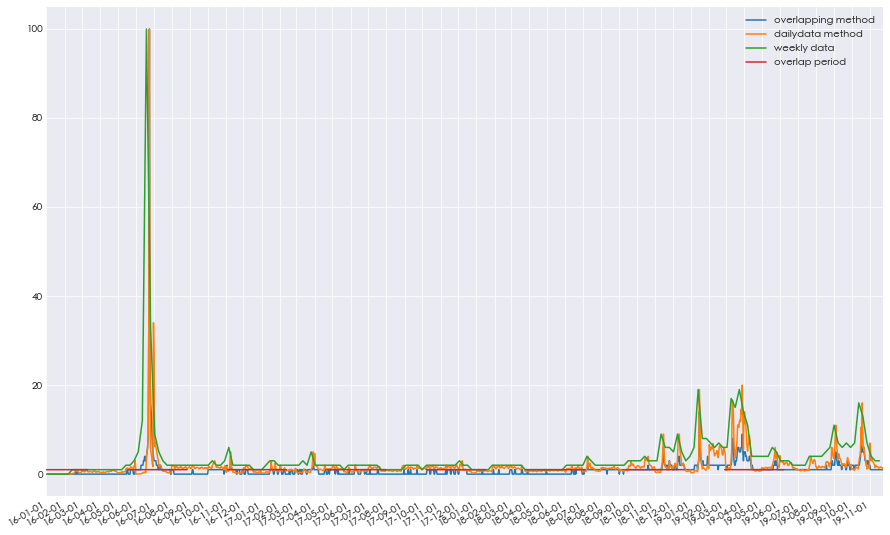

In [25]:
ax = combined2.plot(figsize=(15,10))
# set monthly locator
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()

plt.show()

The overlap periods within 2016 Aug to 2018 Aug have very low search volumes compared to the peak in 2016 Jul. As a result, using the maximum value in such overlap period would probably introduce unrealistic scaling factor (for example, if max of one period is 1 and another is 2, it will result in 200% scale, but the 1 or 2 values could just be some noise)

Use plotly to have better visualization

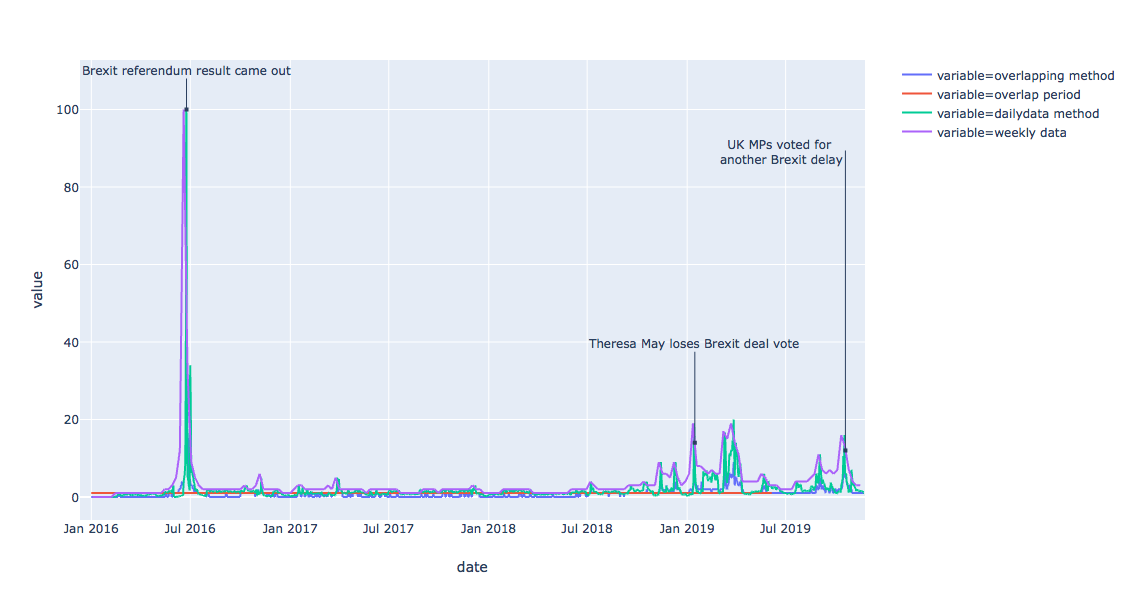

In [27]:
combined_m = pd.melt(combined.reset_index(), id_vars='date')
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(combined_m, x='date', y='value', color='variable')

fig.add_annotation(
    go.layout.Annotation(
            x='2016-06-24',
            y=100,
            text="Brexit referendum result came out",
            ax=0,
            ay=-40
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-01-15',
            y=14,
            text="Theresa May loses Brexit deal vote", 
            ax=0, 
            ay=-100
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-10-19',
            y=12,
            text="UK MPs voted for <br />another Brexit delay",
            xanchor='right',
            ax=0,
            ay=-300
    )
)
fig.update_annotations(dict(
            xref="x",
            yref="y",
            showarrow=True,
            arrowhead=7
))

fig.show()

Let's focus on a shorter period, such as 2017 Jul to 2017 Dec where the trend data varies a lot and 3 methods gave quite different values. In this case, we can even fetch the 'real' daily data directly from google trend (period less then 9 months) without doing any scaling/processing for comparison. 

In [28]:
p_start = '2016-05-01'
p_end = '2016-12-31'
# p_start_d = datetime.strptime(p_start, '%Y%m%d')
# p_end_d = datetime.strptime(p_end, '%Y%m%d')
tf = p_start+' '+p_end

pytrend.build_payload(kw_list=[keyword], cat=cat, geo=geo, gprop=gprop, timeframe=tf)
daily_real = pytrend.interest_over_time()

In [32]:
combined_period = combined.loc[p_start:p_end]
combined_period  = pd.concat([combined_period,daily_real], axis=1)
combined_period.drop(columns=['isPartial','overlap period'], inplace=True)
combined_period.columns=['overlapping', 'dailydata', 'week_interp','daily_real']

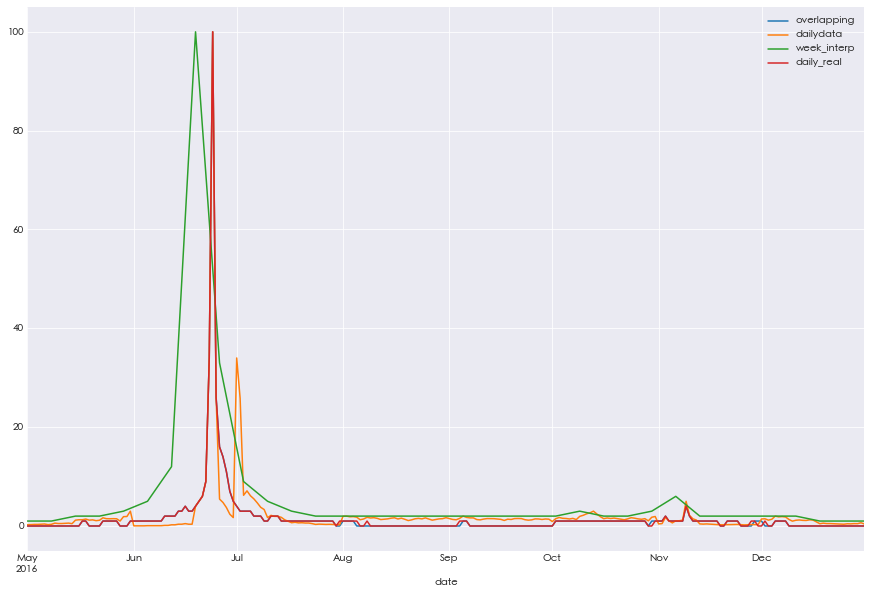

In [33]:
combined_period.plot(figsize=(15,10))

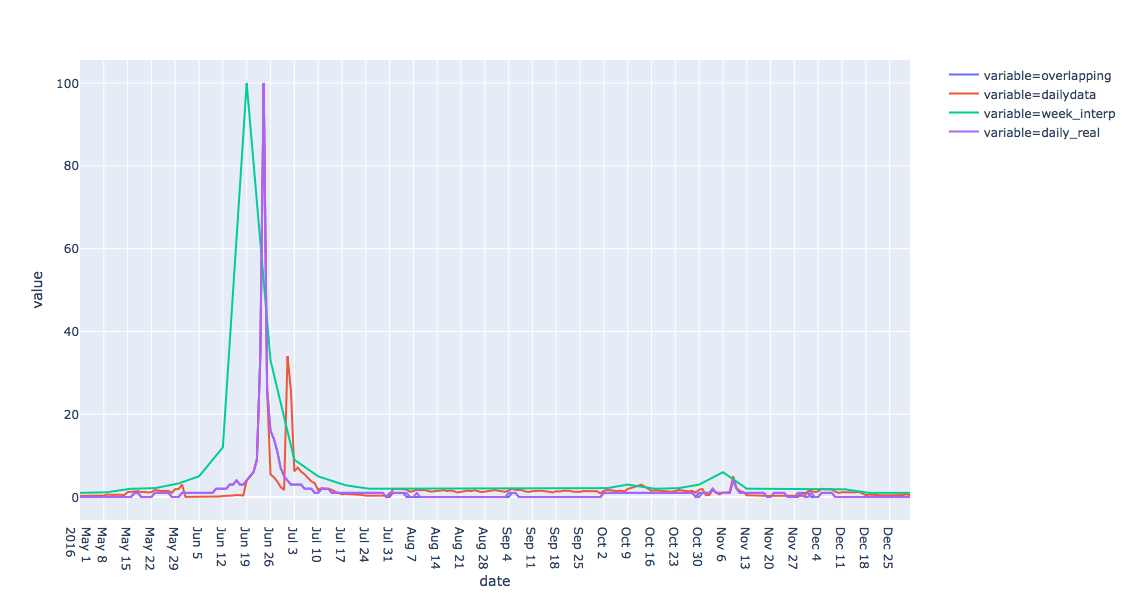

In [35]:
period_m = pd.melt(combined_period.reset_index(), id_vars='date')

fig = px.line(period_m, x='date', y='value', color='variable')
fig.update_layout(xaxis = dict(
                    tickmode = 'linear',
                    tick0 = '2017-07-02',  # start on sunday
                    dtick = (7*86400000.0) # tick spaced for every 7 days
                )
                )
fig.show()

# xaxis = {
#    'tickformat': '%Y-%m-%d',
#    'tickmode': 'auto',
#    'nticks': value, [where value is the max # of ticks]
#    'tick0': value, [where value is the first tick]
#    'dtick': value [where value is the step between ticks]
# }

In [36]:
raw = pd.read_csv('GBP.csv', names=['date', 'GBP/USD'])

raw['date'] = pd.to_datetime(raw.date, format='%d %b %Y')
raw.set_index('date', drop=True, inplace=True)
raw.head()

GBP/USD
date                
2014-11-22  1.567410
2014-11-23  1.566048
2014-11-24  1.566048
2014-11-25  1.570265
2014-11-26  1.571771

In [37]:
GBP = raw[start_d:end_d]*100
GBP.columns = ['GBP/USD rate*100']
GBP.head()

GBP/USD rate*100
date                        
2016-01-01          147.3839
2016-01-02          147.4448
2016-01-03          147.4448
2016-01-04          147.4448
2016-01-05          146.8321

In [39]:
combined_GBP.columns

Index(['overlapping method', 'overlap period', 'dailydata method',
       'weekly data', 'GBP/USD rate*100'],
      dtype='object')

In [42]:
combined_GBP = pd.concat([combined, GBP], axis=1)
combined_GBP.drop(columns=['dailydata method', 'weekly data', 'overlap period'], inplace=True)

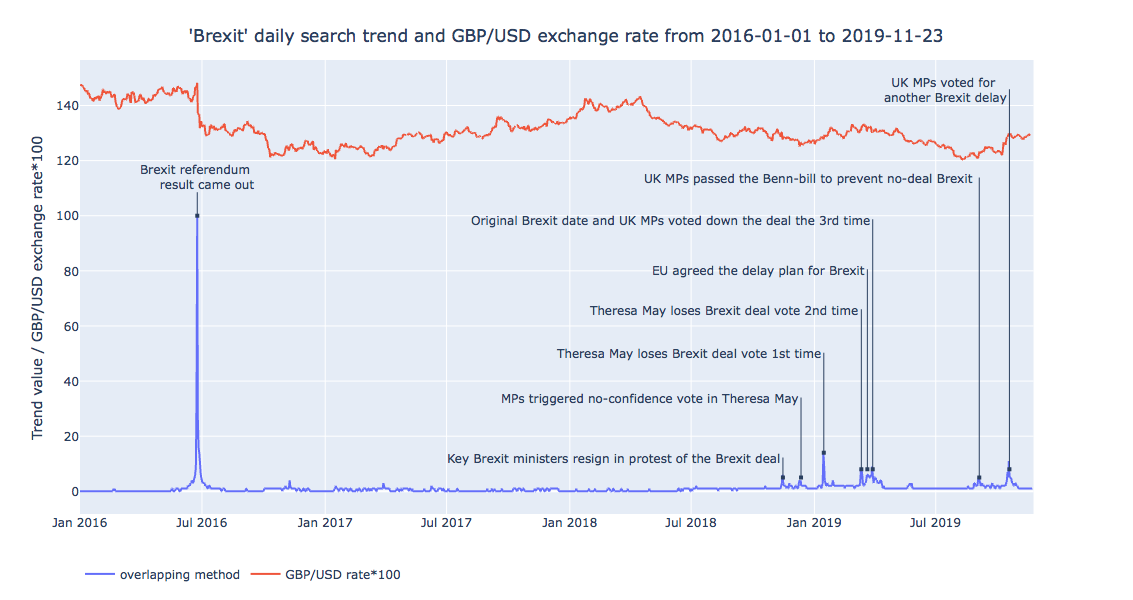

In [46]:
combined_GBP_m = pd.melt(combined_GBP.reset_index(), id_vars='date')
import plotly.express as px
import plotly.graph_objects as go

fig = px.line(combined_GBP_m, x='date', y='value', color='variable').for_each_trace(lambda t: t.update(name=t.name.replace("variable=","")))


fig.add_annotation(
    go.layout.Annotation(
            x='2016-06-24',
            y=100,
            text="Brexit referendum <br />result came out",
            align='right',
            ax=0,
            ay=-40
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2018-11-15',
            y=5,
            text="Key Brexit ministers resign in protest of the Brexit deal",
            align='right',
            xanchor='right',
            ax=0,
            ay=-20
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2018-12-12',
            y=5,
            text="MPs triggered no-confidence vote in Theresa May",
            align='right',
            xanchor='right',
            ax=0,
            ay=-80
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-01-15',
            y=14,
            text="Theresa May loses Brexit deal vote 1st time", 
            align='right',
            xanchor='right',
            ax=0, 
            ay=-100
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-03-12',
            y=8,
            text="Theresa May loses Brexit deal vote 2nd time", 
            align='right',
            xanchor='right',
            ax=0, 
            ay=-160
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-03-21',
            y=8,
            text="EU agreed the delay plan for Brexit", 
            xanchor='right',
            ax=0, 
            ay=-200
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-03-29',
            y=8,
            text="Original Brexit date and UK MPs voted down the deal the 3rd time", 
            align='right',
            xanchor='right',
            ax=0, 
            ay=-250
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-09-04',
            y=5,
            text="UK MPs passed the Benn-bill to prevent no-deal Brexit ",
            xanchor='right',
            align='right',
            ax=0,
            ay=-300
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-10-19',
            y=8,
            text="UK MPs voted for <br />another Brexit delay",
            xanchor='right',
            ax=0,
            ay=-380
    )
)
fig.update_annotations(dict(
            xref="x",
            yref="y",
            showarrow=True,
            arrowhead=7
))

fig.update_layout(
    title={
        'text': "\'Brexit\' daily search trend and GBP/USD exchange rate from "+start+" to "+end,
#         'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title=None,
    yaxis_title="Trend value / GBP/USD exchange rate*100",
    legend_orientation="h"

#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="#7f7f7f"
#     )
)


fig.show()

In [49]:
pytrend = TrendReq(hl='en-US')
keyword = 'brexit'
start = '2018-10-01'
end = '2019-11-23'
# start_d = datetime.strptime(start, '%Y-%m-%d')
# end_d = datetime.strptime(end, '%Y-%m-%d')

In [50]:
daily = gtrend.get_daily_trend(pytrend, keyword, start, end, geo=geo, cat=cat, gprop=gprop, verbose=False)

In [51]:
daily.drop(columns='overlap', inplace=True)

In [71]:
tf = start+' '+end
pytrend.build_payload(kw_list=[keyword], cat=cat, geo=geo, gprop=gprop, timeframe=tf)
week = pytrend.interest_over_time()
week_interp = week.resample('D').mean()
week_interp[f'{keyword}'] = week_interp[f'{keyword}'].interpolate()

In [72]:
week_interp.drop(columns='isPartial', inplace=True)
GBP = raw[start_d:end_d]*100
df = pd.concat([daily,week_interp], axis=1)
df.columns = ['daily trend', 'weekly trend']

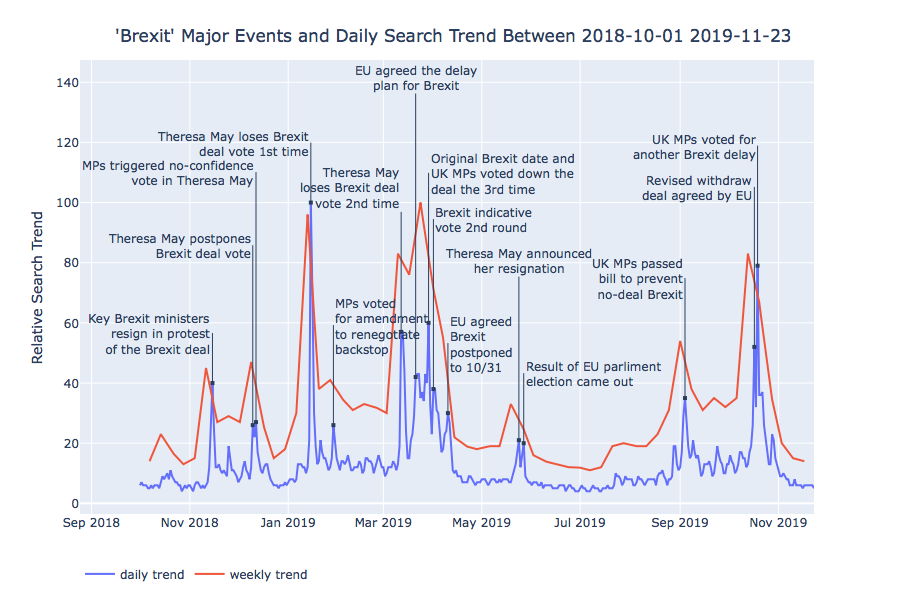

In [73]:
df_m = pd.melt(df.reset_index(), id_vars='date')

fig = px.line(df_m, x='date', y='value', color='variable').for_each_trace(lambda t: t.update(name=t.name.replace("variable=","")))

fig.add_annotation(
    go.layout.Annotation(
            x='2018-11-15',
            y=df.loc['2018-11-15', 'daily trend'],
            text="Key Brexit ministers<br />resign in protest<br />of the Brexit deal",
            align='right',
            xanchor='right',
            ax=0,
            ay=-50
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2018-12-10',
            y=df.loc['2018-12-10', 'daily trend'],
            text="Theresa May postpones<br />Brexit deal vote",
            align='right',
            xanchor='right',
            ax=0,
            ay=-180
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2018-12-12',
            y=df.loc['2018-12-12', 'daily trend'],
            text="MPs triggered no-confidence<br />vote in Theresa May",
            align='right',
            xanchor='right',
            ax=0,
            ay=-250
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-01-15',
            y=df.loc['2019-01-15', 'daily trend'],
            text="Theresa May loses Brexit<br />deal vote 1st time", 
            align='right',
            xanchor='right',
            ax=0, 
            ay=-60
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-01-29',
            y=df.loc['2019-01-29', 'daily trend'],
            text="MPs voted<br />for amendment<br />to renegotiate<br />backstop", 
            align='left',
            xanchor='left',
            ax=0, 
            ay=-100
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-03-12',
            y=df.loc['2019-03-12', 'daily trend'],
            text="Theresa May<br />loses Brexit deal<br />vote 2nd time", 
            align='right',
            xanchor='right',
            yanchor='bottom',
            ax=0, 
            ay=-120
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-03-21',
            y=df.loc['2019-03-21', 'daily trend'],
            text="EU agreed the delay<br />plan for Brexit", 
            align='center',
            xanchor='center',
            ax=0, 
            ay=-300
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-03-29',
            y=df.loc['2019-03-29', 'daily trend'],
            text="Original Brexit date and<br />UK MPs voted down the<br />deal the 3rd time", 
            align='left',
            xanchor='left',
            ax=0, 
            ay=-150
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-04-01',
            y=df.loc['2019-04-01', 'daily trend'],
            text="Brexit indicative<br />vote 2nd round", 
            align='left',
            xanchor='left',
            ax=0, 
            ay=-170
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-04-10',
            y=df.loc['2019-04-10', 'daily trend'],
            text="EU agreed<br \>Brexit<br \>postponed<br \>to 10/31", 
            align='left',
            xanchor='left',
            ax=0, 
            ay=-70
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-05-24',
            y=df.loc['2019-05-24', 'daily trend'],
            text="Theresa May announced<br />her resignation", 
            align='center',
            xanchor='center',
            ax=0, 
            ay=-180
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-05-27',
            y=df.loc['2019-05-27', 'daily trend'],
            text="Result of EU parliment<br />election came out", 
            align='left',
            xanchor='left',
            ax=0, 
            ay=-70
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-09-04',
            y=df.loc['2019-09-04', 'daily trend'],
            text="UK MPs passed<br />bill to prevent<br />no-deal Brexit ",
            xanchor='right',
            align='right',
            ax=0,
            ay=-120
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-10-17',
            y=df.loc['2019-10-17', 'daily trend'],
            text="Revised withdraw<br />deal agreed by EU",
            align='right',
            xanchor='right',
            ax=0,
            ay=-160
    )
)
fig.add_annotation(
    go.layout.Annotation(
            x='2019-10-19',
            y=df.loc['2019-10-19', 'daily trend'],
            text="UK MPs voted for<br />another Brexit delay",
            align='right',
            xanchor='right',
            ax=0,
            ay=-120
    )
)
fig.update_annotations(dict(
            xref="x",
            yref="y",
            showarrow=True,
            arrowhead=7
))

fig.update_layout(
    title={
        'text': "\'Brexit\' Major Events and Daily Search Trend Between "+start+" "+end,
#         'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title=None,
    yaxis_title="Relative Search Trend",
    legend_orientation="h"

#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="#7f7f7f"
#     )
)


fig.show()

In [66]:
df = pd.concat([daily,GBP], axis=1)
df.columns = ['Google Search Trends', 'GBP exchange rate']
df_m = pd.melt(df.reset_index(), id_vars='date')

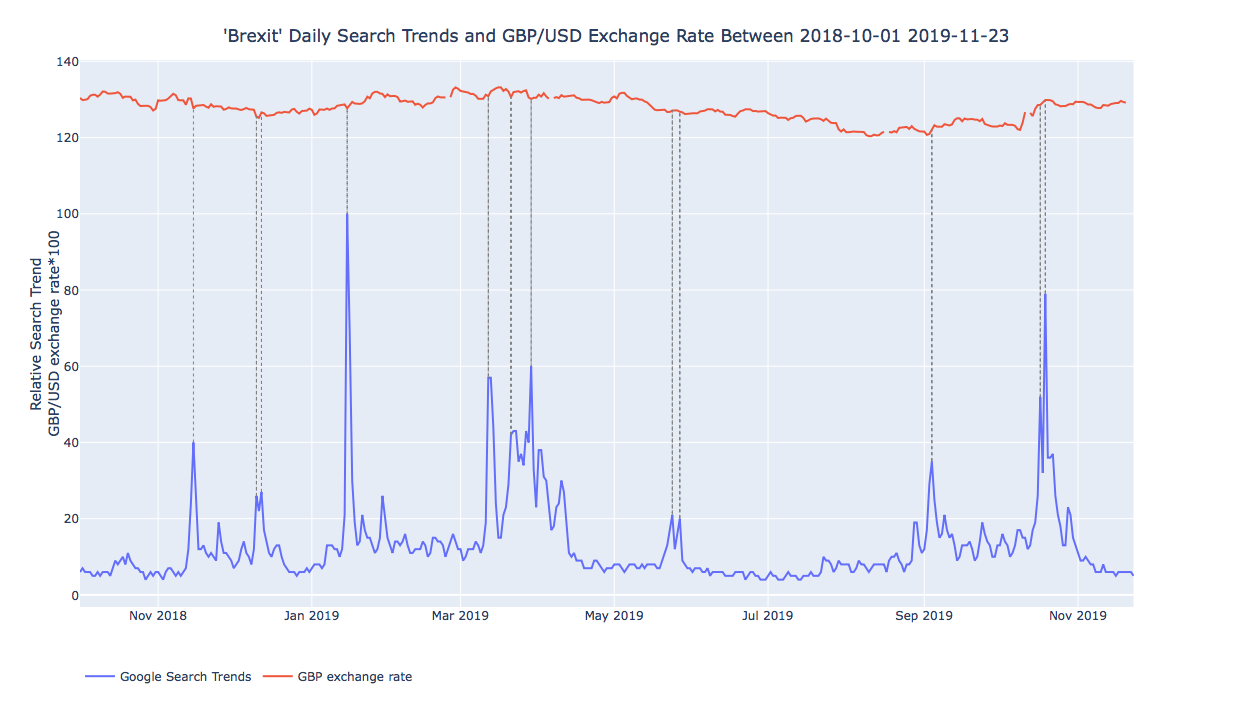

In [68]:
fig = px.line(df_m, x='date', y='value', color='variable').for_each_trace(lambda t: t.update(name=t.name.replace("variable=","")))

fig.add_shape(
    go.layout.Shape(
            type='line',
            x0='2018-11-15',
            y0=df.loc['2018-11-15'].iloc[0],
            x1='2018-11-15',
            y1=df.loc['2018-11-15'].iloc[1]
    )
)
fig.add_shape(
    go.layout.Shape(
            x0='2018-12-10',
            y0=df.loc['2018-12-10'].iloc[0],
            x1='2018-12-10',
            y1=df.loc['2018-12-10'].iloc[1]
    )
)
fig.add_shape(
    go.layout.Shape(
            x0='2018-12-12',
            y0=df.loc['2018-12-12'].iloc[0],
            x1='2018-12-12',
            y1=df.loc['2018-12-12'].iloc[1]
    )
)
fig.add_shape(
    go.layout.Shape(
            x0='2019-01-15',
            y0=df.loc['2019-01-15'].iloc[0],
            x1='2019-01-15', 
            y1=df.loc['2019-01-15'].iloc[1]
    )
)
fig.add_shape(
    go.layout.Shape(
            x0='2019-03-12',
            y0=df.loc['2019-03-12'].iloc[0],
            x1='2019-03-12', 
            y1=df.loc['2019-03-12'].iloc[1]
    )
)
fig.add_shape(
    go.layout.Shape(
            x0='2019-03-21',
            y0=df.loc['2019-03-21'].iloc[0],
            x1='2019-03-21', 
            y1=df.loc['2019-03-21'].iloc[1]
    )
)
fig.add_shape(
    go.layout.Shape(
            x0='2019-03-29',
            y0=df.loc['2019-03-29'].iloc[0],
            x1='2019-03-29', 
            y1=df.loc['2019-03-29'].iloc[1]
    )
)
fig.add_shape(
    go.layout.Shape(
            x0='2019-05-24',
            y0=df.loc['2019-05-24'].iloc[0],
            x1='2019-05-24', 
            y1=df.loc['2019-05-24'].iloc[1]
    )
)
fig.add_shape(
    go.layout.Shape(
            x0='2019-05-27',
            y0=df.loc['2019-05-27'].iloc[0],
            x1='2019-05-27', 
            y1=df.loc['2019-05-27'].iloc[1]
    )
)
fig.add_shape(
    go.layout.Shape(
            x0='2019-09-04',
            y0=df.loc['2019-09-04'].iloc[0],
            x1='2019-09-04',
            y1=df.loc['2019-09-04'].iloc[1]
    )
)
fig.add_shape(
    go.layout.Shape(
            x0='2019-10-17',
            y0=df.loc['2019-10-17'].iloc[0],
            x1='2019-10-17',
            y1=df.loc['2019-10-17'].iloc[1]
    )
)
fig.add_shape(
    go.layout.Shape(
            x0='2019-10-19',
            y0=df.loc['2019-10-19'].iloc[0],
            x1='2019-10-19',
            y1=df.loc['2019-10-19'].iloc[1]
    )
)
fig.update_shapes(dict(
            xref="x",
            yref="y",
            line=dict(
                color="gray",
                width=1,
                dash='dot'
                )
        )
)
fig.update_layout(
    title={
        'text': "\'Brexit\' Daily Search Trends and GBP/USD Exchange Rate Between "+start+" "+end,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title=None,
    yaxis_title="Relative Search Trend<br \>GBP/USD exchange rate*100",
    legend_orientation="h"

)


fig.show()